# MC1

## Intro

Country Theme: INDIA

Signal: Indian traffic sounds

Student: Shwetav Behera

Date: October 26, 2025

Data Source: https://www.youtube.com/shorts/K-3qSmt8Qgg


## Day 1: UnderstandingNyquist-Shannon Sampling Theorem - Understanding

**USE CASE**

In busy Indian cities, traffic management systems increasingly rely on acoustic monitoring to detect congestion, emergency vehicles, and traffic violations. Street horns are characteristic acoustic signatures of Indian roads. Many small compute devices (Like Rasberry Pi or Arduino) could be placed in e certain distance on roads to identify conjestion and report to emergency vehicle services about conjested roads.

These devices have imited processing power, memory, and storage. A lower sampling rate reduces computational load but risks missing critical frequency components or introducing aliasing artifacts that could cause the system to misidentify horn types.

The challenge is to identify the minimum sampling rate that preserves the essential harmonic and timbral characteristics of Indian street horns while keeping the system deployable on low-ressource devices.

**PROBLEM STATEMENT**

What is the lowest audio sampling rate that still captures the fundamental frequencies and harmonic overtones of Indian vehicle horns while maintaining computational efficiency for real-time edge processing?


**OBJECTIVE**

Determine the optimal sampling rate for Indian street horn acoustic monitoring by:

1. Analyzing the frequency content and harmonic structure of street horn audio
2. Calculating the Nyquist rate based on the highest significant frequency component
3. Demonstrating proper and improper sampling rates
4. Showing aliasing effects and harmonic distortion when under-sampling occurs
5. Validating that the chosen sampling rate preserves horn identification accuracy

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import resample_poly
import pandas as pd
import IPython.display as ipd
import time

In [2]:
y, sr = librosa.load("data/mumbai_traffic.mp3", sr=None, mono=True)

In [3]:
# Display basic information
print(f"Original Sample Rate: {sr} Hz")
print(f"Audio Duration: {len(y)/sr:.2f} seconds")
print(f"Total Samples: {len(y)}")
print(f"Audio Shape: {y.shape}")

# Play the audio
print("\nOriginal Audio:")
ipd.display(ipd.Audio(y, rate=sr))

Original Sample Rate: 44100 Hz
Audio Duration: 12.21 seconds
Total Samples: 538624
Audio Shape: (538624,)

Original Audio:


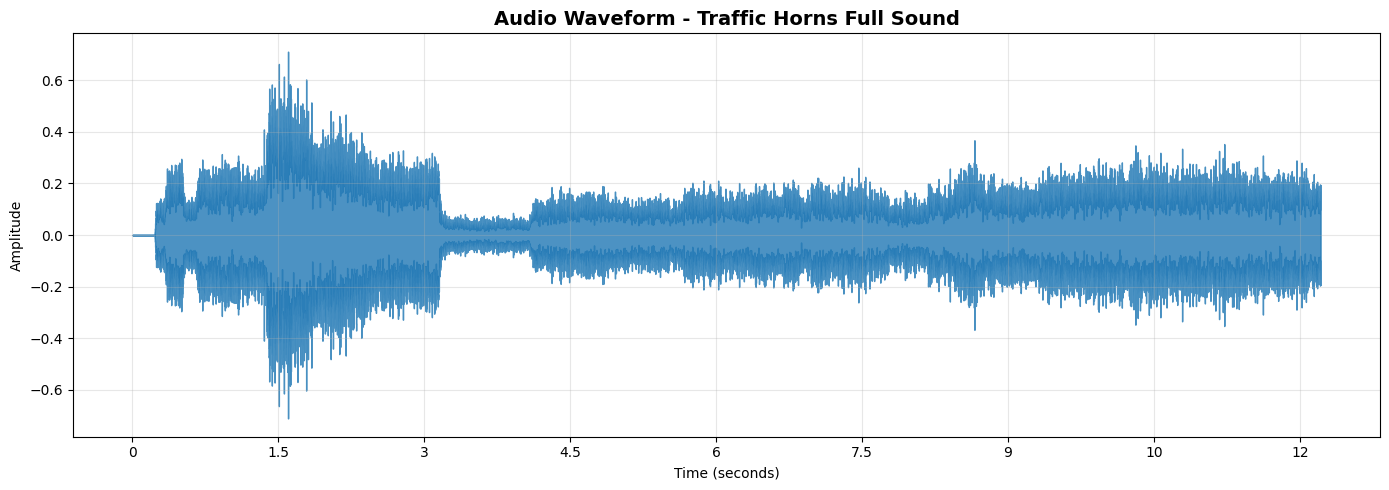

In [19]:
# Create a figure with the waveform
plt.figure(figsize=(14, 5))

# Plot the waveform
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title('Audio Waveform - Traffic Horns Full Sound', fontsize=14, fontweight='bold')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

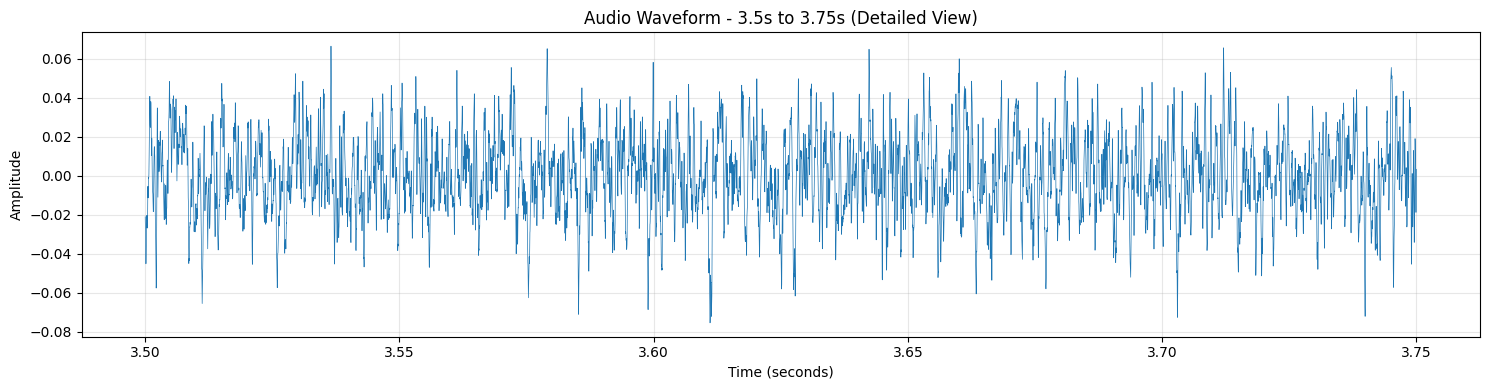

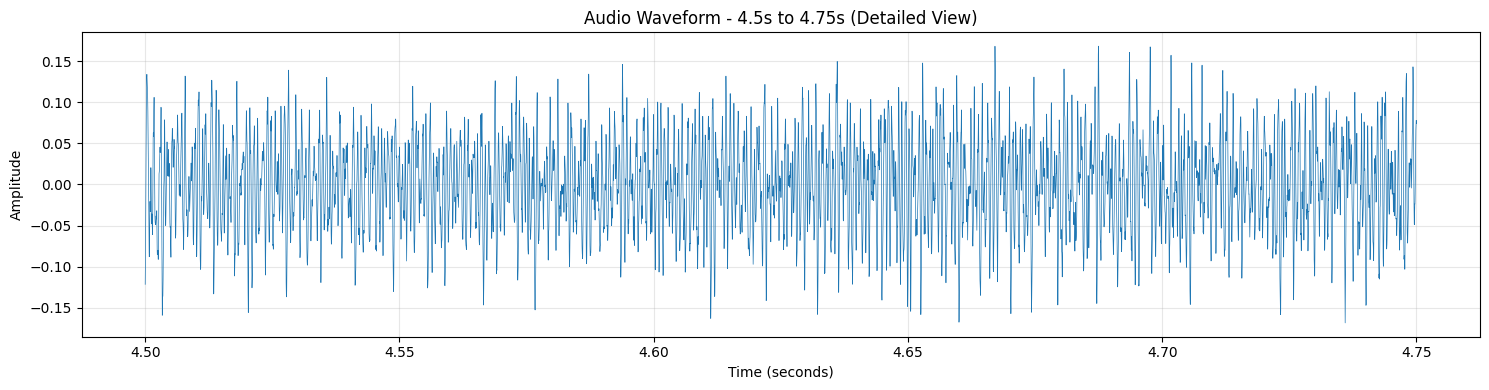

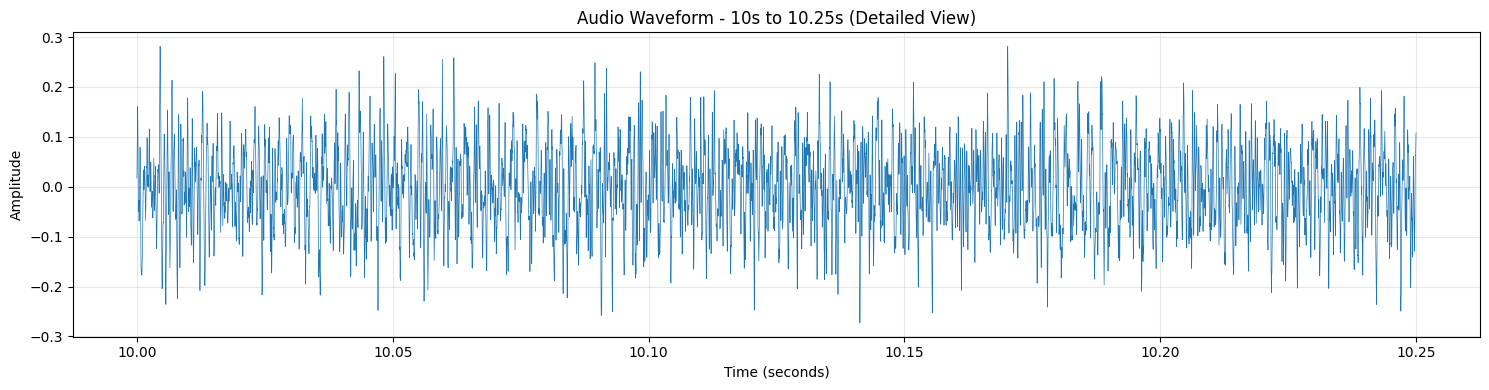

In [18]:
def plot_zoomed_waveform(y, sr, start_time, end_time):
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_segment = y[start_sample:end_sample]
    time_segment = np.linspace(start_time, end_time, len(y_segment))

    plt.figure(figsize=(15, 4))
    plt.plot(time_segment, y_segment, linewidth=0.5)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.title(f'Audio Waveform - {start_time}s to {end_time}s (Detailed View)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# No horns segment from
plot_zoomed_waveform(y, sr, 3.5, 3.75)

# Signle horns segment
plot_zoomed_waveform(y, sr, 4.5, 4.75)

# Multiple horns segment
plot_zoomed_waveform(y, sr, 10, 10.25)

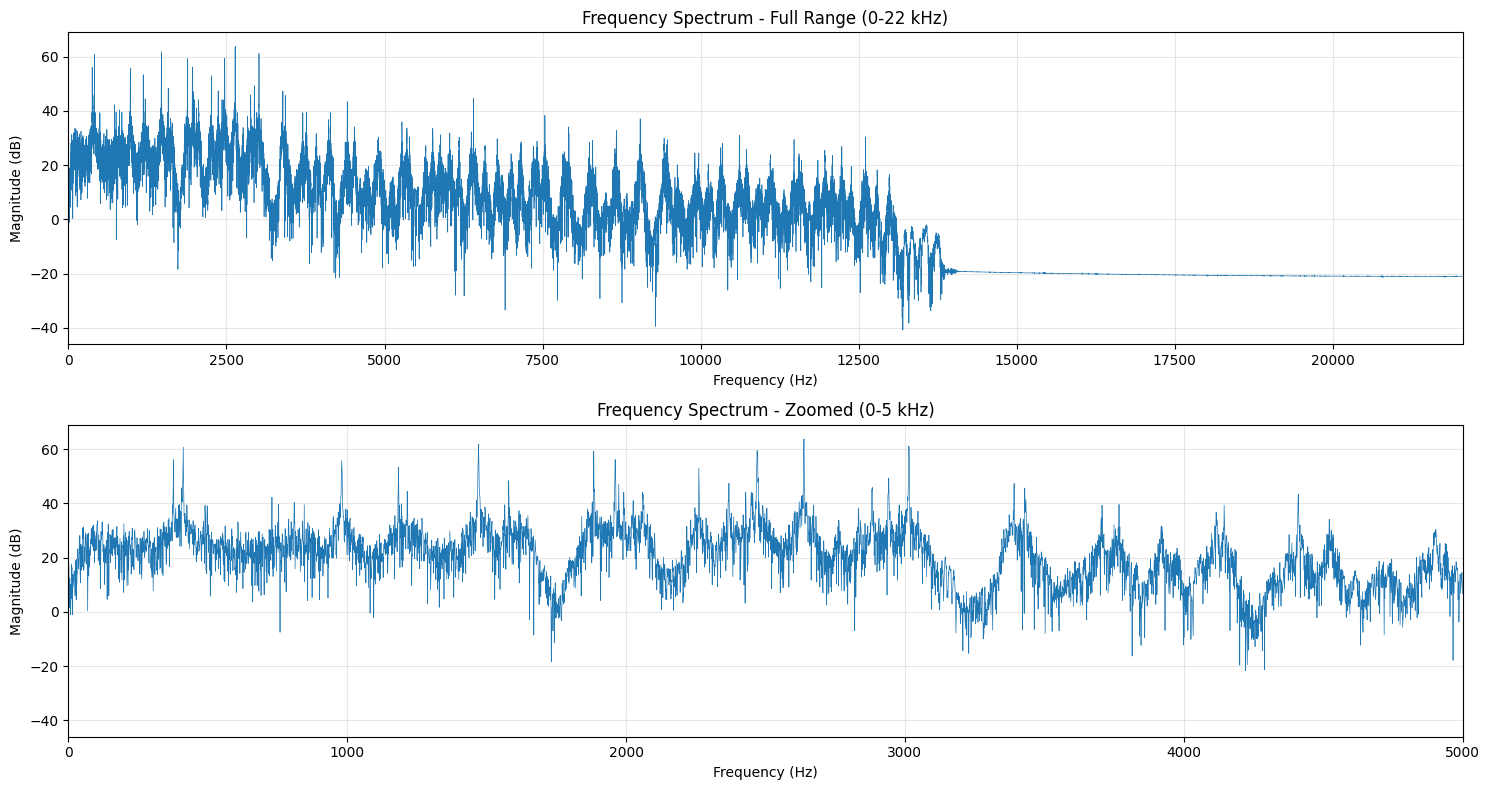


Significant frequency peaks (within 40 dB of maximum):
Highest frequency with significant energy: 12609.3 Hz


In [25]:
# Let's analyze a clear horn section (around 1.5s where we saw the peak)
# We'll take a 1-second window for good frequency resolution
start_time = 1.3
duration = 1.0
start_sample = int(start_time * sr)
end_sample = int((start_time + duration) * sr)

# Extract the segment
horn_segment = y[start_sample:end_sample]

# Compute FFT
fft_result = np.fft.fft(horn_segment)
frequencies = np.fft.fftfreq(len(horn_segment), 1/sr)

# Take only positive frequencies and magnitude
positive_freq_idx = frequencies > 0
frequencies_positive = frequencies[positive_freq_idx]
magnitude = np.abs(fft_result[positive_freq_idx])

# Convert to dB scale for better visualization
magnitude_db = 20 * np.log10(magnitude + 1e-10)  # Add small value to avoid log(0)

# Plot the frequency spectrum
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Full spectrum (0 to 22 kHz - Nyquist frequency of 44.1 kHz)
ax1.plot(frequencies_positive, magnitude_db, linewidth=0.5)
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Magnitude (dB)')
ax1.set_title('Frequency Spectrum - Full Range (0-22 kHz)')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 22050])

# Zoomed to 0-5 kHz (where most horn energy typically is)
ax2.plot(frequencies_positive, magnitude_db, linewidth=0.5)
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Magnitude (dB)')
ax2.set_title('Frequency Spectrum - Zoomed (0-5 kHz)')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 5000])

plt.tight_layout()
plt.show()

# Find peaks in the spectrum
threshold_db = np.max(magnitude_db) - 40  # Peaks within 40 dB of maximum
peak_indices = np.where(magnitude_db > threshold_db)[0]
peak_frequencies = frequencies_positive[peak_indices]
peak_magnitudes = magnitude_db[peak_indices]
max_significant_freq = np.max(peak_frequencies)

print("\nSignificant frequency peaks (within 40 dB of maximum):")
print(f"Highest frequency with significant energy: {max_significant_freq:.1f} Hz")

**The Nyquist Frequency**

In our case would be the highest frequency component present in Indian vehicle horn sounds.


**Fast Fourier Transform (FFT)**

I converted the time domain audio signal into the frequency domain. This shows us which frequencies are present in the the audio data and how strong each frequency is.

We can see, that most energy is below 12609.3 Hz. The signal drops after that. After that it is just noise (visible by the low magnitude).

Since the highest significant frequency is around 12609 Hz, I need a sampling rate of at least 2x this frequency (according to Nyquist-Shannon sampling theorem).

In [28]:
# Calculate Nyquist rate and frequency
nyquist_frequency = max_significant_freq
nyquist_rate = 2 * max_significant_freq
print(f"Maximum significant frequency component (f_max): {max_significant_freq:.1f} Hz")
print(f"Nyquist Frequency (f_Nyquist) = f_max = {nyquist_frequency:.1f} Hz")
print(f"Nyquist Rate (sampling rate) = 2 × f_Nyquist = {nyquist_rate:.1f} Hz")


Maximum significant frequency component (f_max): 12609.3 Hz
Nyquist Frequency (f_Nyquist) = f_max = 12609.3 Hz
Nyquist Rate (sampling rate) = 2 × f_Nyquist = 25218.6 Hz


**The Nyquist Frequency (12609.3 Hz)**

The Nyquist Frequency represents the highest frequency component present in Indian vehicle horn sounds in my data. It is therefore the bandwidth limit of the acoustic signal we need to capture. 

**The Nyquist Rate (25218.6 Hz)**

The Nyquist Rate represents the minimum sampling rate needed to perfectly reconstruct the horn signal. Any sampling rate above this will preserve all frequency information. Any below this rate will cause frequency distortion (aliasing). This is way less than the 44.1 kHz we currently sample at.

## Day 2 Nyquist-Shannon Sampling Theorem - Demonstrating and Aliasing

Now I want to see how the waveforms look at different sampling rates.

For this I will test following rates:
- Original (Overkill):      44100 Hz (1.75× Nyquist)
- Safe (Above Nyquist):     32000 Hz (1.27× Nyquist)
- At Nyquist (Borderline):  25218 Hz (1.00× Nyquist)
- Below Nyquist (Aliasing): 16000 Hz (0.63× Nyquist)
- Severe Undersampling:     8000 Hz (0.32× Nyquist)


In [50]:
# Define sampling rates to test
sampling_rates = {
    'Original (Overkill)': 44100,
    'Safe (Above Nyquist)': 32000,
    'At Nyquist (Borderline)': 25218,
    'Below Nyquist (Aliasing)': 16000,
    'Severe Undersampling': 8000
}

# Extract a clear horn segment for demonstration (1-2 seconds with prominent horn)
demo_start = 1.3
demo_duration = 0.7
start_idx = int(demo_start * sr)
end_idx = int((demo_start + demo_duration) * sr)
demo_signal = y[start_idx:end_idx]

print(f"Using horn segment: {demo_start}s to {demo_start + demo_duration}s")
print(f"Original samples: {len(demo_signal)}")
print()

# Resample to each target rate
resampled_signals = {}
resampled_signals['Original (Overkill)'] = demo_signal

for name, target_sr in list(sampling_rates.items())[1:]:  # Skip original
    resampled = librosa.resample(demo_signal, orig_sr=sr, target_sr=target_sr)
    resampled_signals[name] = resampled
    print(f"Resampled to {name}: {len(resampled)} samples")

Using horn segment: 1.3s to 2.0s
Original samples: 30870

Resampled to Safe (Above Nyquist): 22400 samples
Resampled to At Nyquist (Borderline): 17653 samples
Resampled to Below Nyquist (Aliasing): 11200 samples
Resampled to Severe Undersampling: 5600 samples


As visible in the previous prints, the samples reduced with the sample frequency. 8000 Hz has only 5,600 samples (82% reduction from original sample size).

Now we visualize the waves to see how the different sampling sizes affect the wave precision compared to the original wave.

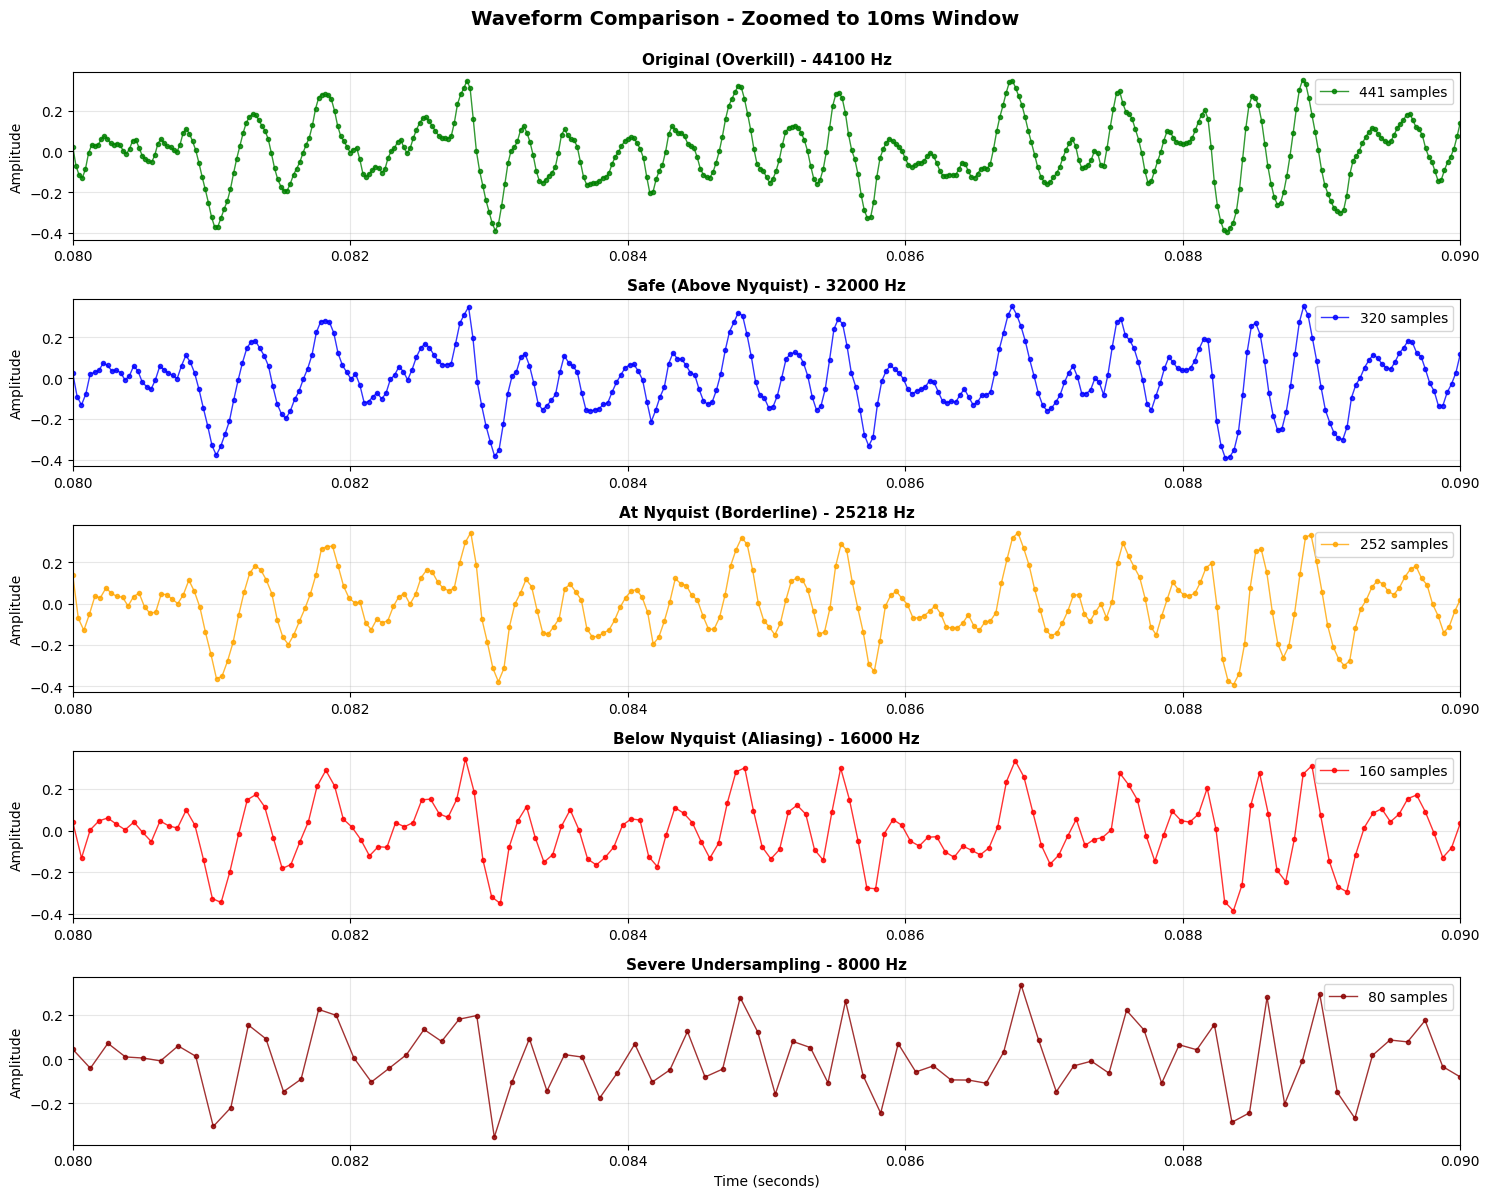

In [43]:
zoom_start = 0.08  # Start at 0.08
zoom_duration = 0.01  # Only 20 milliseconds (0.02 seconds)

fig, axes = plt.subplots(5, 1, figsize=(15, 12))
colors = ['green', 'blue', 'orange', 'red', 'darkred']

for idx, (name, color) in enumerate(zip(sampling_rates.keys(), colors)):
    ax = axes[idx]
    signal = resampled_signals[name]
    rate = sampling_rates[name]
    
    # Calculate sample indices for our zoom window
    start_sample = int(zoom_start * rate)
    end_sample = int((zoom_start + zoom_duration) * rate)
    
    # Extract the zoomed segment
    zoomed_signal = signal[start_sample:end_sample]
    time_axis = np.linspace(zoom_start, zoom_start + zoom_duration, len(zoomed_signal))
    
    # Plot with markers to see individual samples
    ax.plot(time_axis, zoomed_signal, 'o-', linewidth=1, markersize=3, 
            color=color, alpha=0.8, label=f'{len(zoomed_signal)} samples')
    
    ax.set_ylabel('Amplitude')
    ax.set_title(f'{name} - {rate} Hz', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([zoom_start, zoom_start + zoom_duration])
    ax.legend(loc='upper right')
    

axes[-1].set_xlabel('Time (seconds)')
plt.suptitle(f'Waveform Comparison - Zoomed to {zoom_duration*1000:.0f}ms Window', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

We see that
- 44100 Hz (original) has 441 samples. Very smooth curve, captures every detail
- 32000 Hz has 320 samples. Still smooth, waveform almost identical to original.
- 25218 Hz has 252 samples. Wave still captures details compared to original, but some differences are visible (see around 0.08225).
- 16000 Hz has 160 samples. Visibly coarser, missing some details.
- 8000 Hz has 80 samples. Wave is very blocky, there is significant information loss.

At 16000 and 8000 Hz fast oszilations aren't being captured.

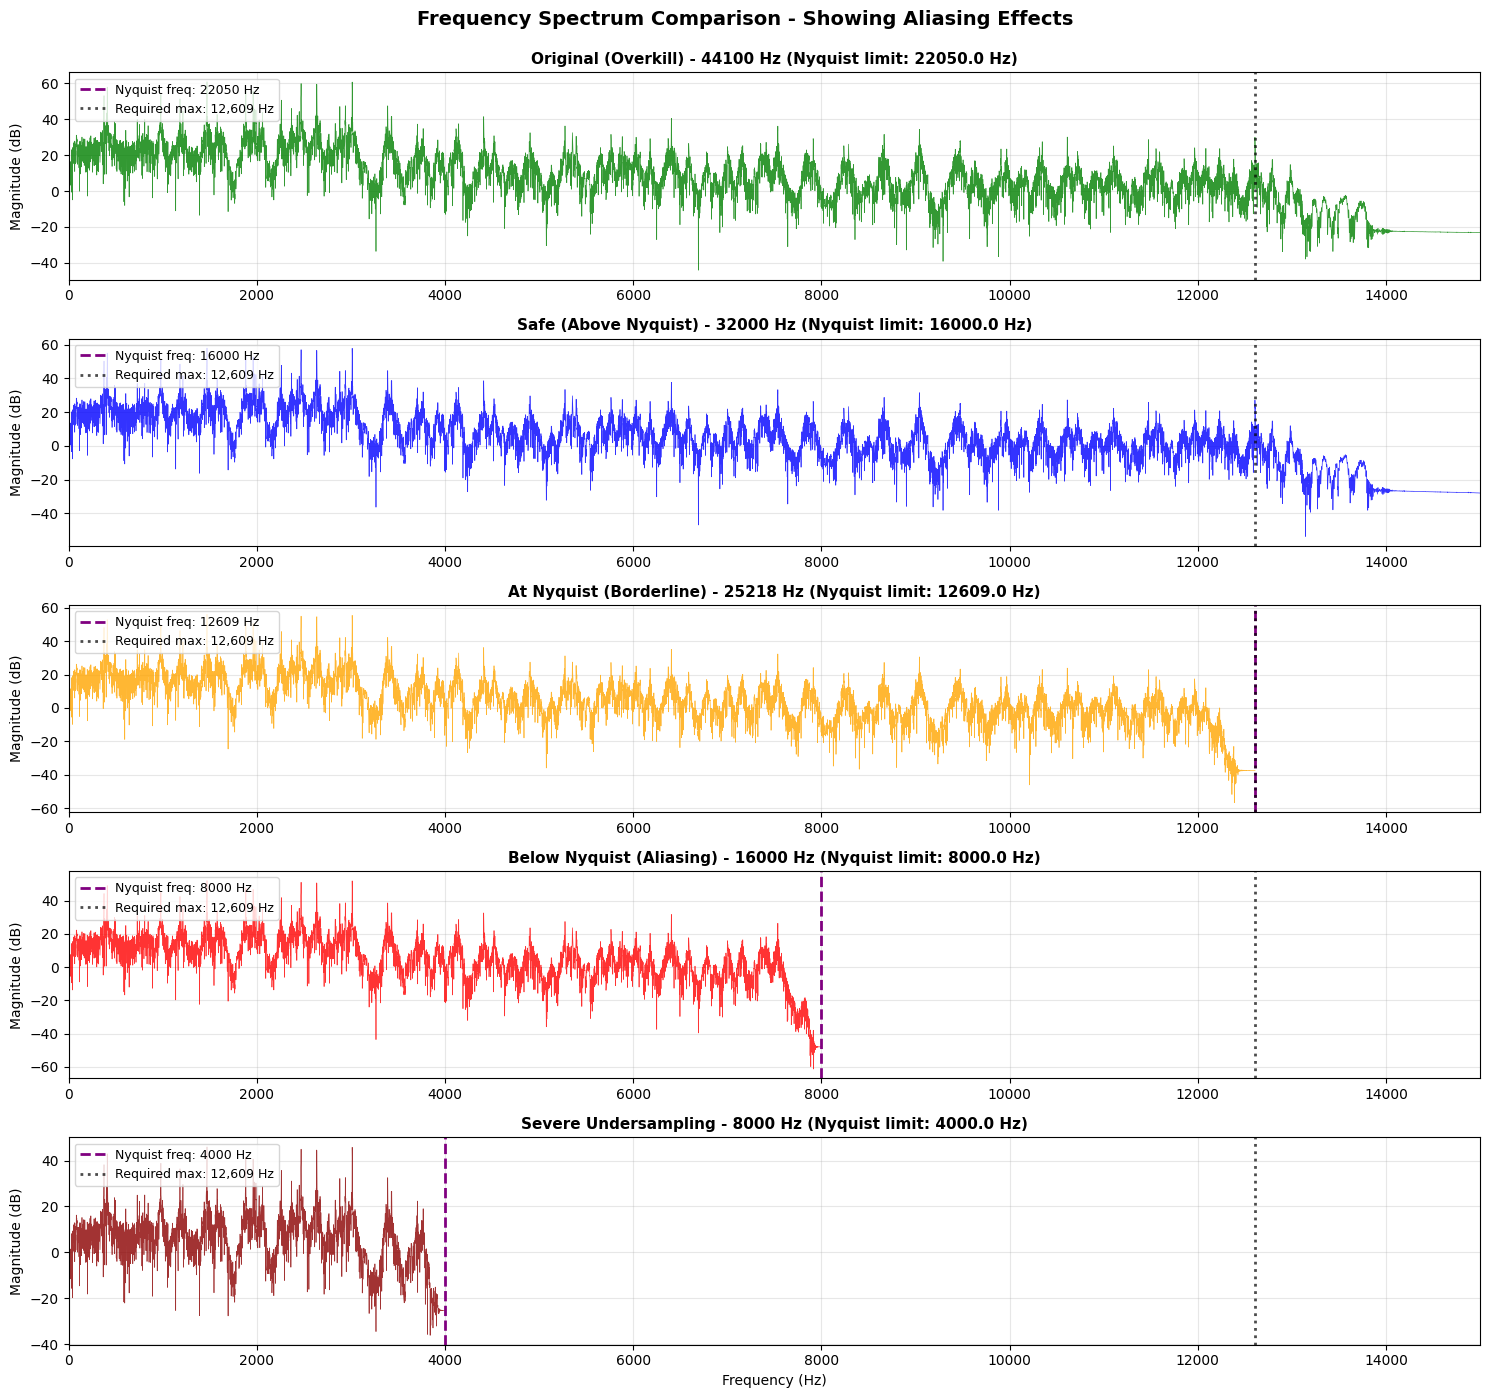

In [46]:
# Compute FFT for each resampled version
fig, axes = plt.subplots(5, 1, figsize=(15, 14))
colors = ['green', 'blue', 'orange', 'red', 'darkred']

for idx, (name, color) in enumerate(zip(sampling_rates.keys(), colors)):
    ax = axes[idx]
    signal = resampled_signals[name]
    rate = sampling_rates[name]
    
    # Compute FFT
    fft_result = np.fft.fft(signal)
    frequencies = np.fft.fftfreq(len(signal), 1/rate)
    
    # Take positive frequencies only
    positive_idx = frequencies > 0
    freqs = frequencies[positive_idx]
    magnitude = np.abs(fft_result[positive_idx])
    magnitude_db = 20 * np.log10(magnitude + 1e-10)
    
    # Plot
    ax.plot(freqs, magnitude_db, linewidth=0.5, color=color, alpha=0.8)
    ax.set_ylabel('Magnitude (dB)')
    ax.set_title(f'{name} - {rate} Hz (Nyquist limit: {rate/2} Hz)', 
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 15000])
    
    # Draw vertical line at Nyquist frequency
    nyquist_freq = rate / 2
    ax.axvline(nyquist_freq, color='purple', linestyle='--', linewidth=2, 
               label=f'Nyquist freq: {nyquist_freq:.0f} Hz')
    
    # Draw line at our required max frequency (12.6 kHz)
    ax.axvline(12609, color='black', linestyle=':', linewidth=2, alpha=0.7,
               label='Required max: 12,609 Hz')
    
    
    ax.legend(loc='upper left', fontsize=9)

axes[-1].set_xlabel('Frequency (Hz)')
plt.suptitle('Frequency Spectrum Comparison - Showing Aliasing Effects', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

Looking at the frequency spectrum, we see the following:

In the top 3 plots the samnpling rate extends beyond the required 12609 Hz (black dotted line). Their Nyquist limit (purple dashed line) is at or above our maximum frequency. The spectrum also looks similar.

In the bottom 2 plots the spectrums cut off suddenly at their Nyquist limits. All information above the limit is lost. This results in muffles and distorted sound.

In [53]:


for name in sampling_rates.keys():
    signal = resampled_signals[name]
    rate = sampling_rates[name]
    
    print(f"\n{name} ({rate} Hz)")
    print("-" * 50)
    
    ipd.display(ipd.Audio(signal, rate=rate))
    print()


Original (Overkill) (44100 Hz)
--------------------------------------------------




Safe (Above Nyquist) (32000 Hz)
--------------------------------------------------




At Nyquist (Borderline) (25218 Hz)
--------------------------------------------------




Below Nyquist (Aliasing) (16000 Hz)
--------------------------------------------------




Severe Undersampling (8000 Hz)
--------------------------------------------------
